CODE BLOCK: 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [ ]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [ ]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

In [ ]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

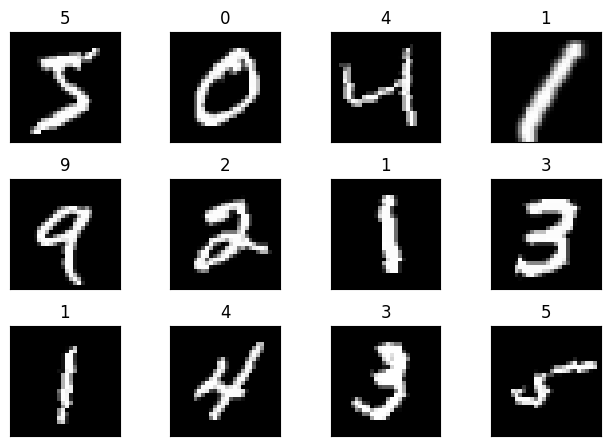

In [ ]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm

class Utils:
  def __init__(self):
    pass

  def prepare_data(self):

    train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

    # Test data transformations
    test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
    test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)
    return train_data, test_data

  def load_data(self, train_data, test_data):
    batch_size = 512
    kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
    train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

  def visualize_data(self, train_loader):
    batch_data, batch_label = next(iter(train_loader))

    fig = plt.figure()

    for i in range(12):
      plt.subplot(3,4,i+1)
      plt.tight_layout()
      plt.imshow(batch_data[i].squeeze(0), cmap='gray')
      plt.title(batch_label[i].item())
      plt.xticks([])
      plt.yticks([])

  def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

  def train(self, model, device, train_loader, optimizer, criterion):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()

      # Predict
      pred = model(data)

      # Calculate loss
      loss = criterion(pred, target)
      train_loss+=loss.item()

      # Backpropagation
      loss.backward()
      optimizer.step()

      correct += self.GetCorrectPredCount(pred, target)
      processed += len(data)

      pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))

  def test(self, model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction = 'sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))



  def train_and_evaluate_model(self):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if self.use_cuda else "cpu")
    model = Net().to(self.device)
    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []

    test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
    criterion = F.cross_entropy
    num_epochs = 20

    for epoch in range(1, num_epochs+1):
      print(f'Epoch {epoch}')
      self.train(model, device, train_loader, optimizer, criterion)
      self.test(model, device, test_loader, criterion)
      scheduler.step()

    return train_losses, test_losses, train_acc, test_acc

  def plot_losses_and_accuracy(self, train_losses, train_acc, test_losses, test_acc):
      fig, axs = plt.subplots(2,2,figsize=(15,10))
      axs[0, 0].plot(train_losses)
      axs[0, 0].set_title("Training Loss")
      axs[1, 0].plot(train_acc)
      axs[1, 0].set_title("Training Accuracy")
      axs[0, 1].plot(test_losses)
      axs[0, 1].set_title("Test Loss")
      axs[1, 1].plot(test_acc)
      axs[1, 1].set_title("Test Accuracy")

  def runMnistModel(self):
    train_data , test_data = self.prepare_data()
    train_loader, test_loader = self.load_data(train_data, test_data)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model = Net().to(device)
    train_losses, train_acc, test_losses, test_acc = self.train_and_evaluate_model()
    self.plot_losses_and_accuracy(train_losses, train_acc, test_losses, test_acc)


CODE BLOCK: 7

In [ ]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(4096, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv3(x), 2)
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
        x = x.view(-1, 4096)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


CODE BLOCK: 8

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [ ]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction = 'sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.cross_entropy
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.5915 Batch_id=117 Accuracy=36.90: 100%|██████████| 118/118 [00:21<00:00,  5.44it/s]


Test set: Average loss: 0.8129, Accuracy: 7530/10000 (75.30%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.2568 Batch_id=117 Accuracy=90.81: 100%|██████████| 118/118 [00:20<00:00,  5.87it/s]


Test set: Average loss: 0.1032, Accuracy: 9674/10000 (96.74%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.2326 Batch_id=117 Accuracy=95.76: 100%|██████████| 118/118 [00:19<00:00,  5.96it/s]


Test set: Average loss: 0.0694, Accuracy: 9760/10000 (97.60%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.1780 Batch_id=117 Accuracy=96.94: 100%|██████████| 118/118 [00:20<00:00,  5.68it/s]


Test set: Average loss: 0.0518, Accuracy: 9832/10000 (98.32%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.1390 Batch_id=117 Accuracy=97.44: 100%|██████████| 118/118 [00:20<00:00,  5.71it/s]


Test set: Average loss: 0.0533, Accuracy: 9815/10000 (98.15%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.1262 Batch_id=117 Accuracy=97.76: 100%|██████████| 118/118 [00:20<00:00,  5.66it/s]


Test set: Average loss: 0.0493, Accuracy: 9836/10000 (98.36%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.1290 Batch_id=117 Accuracy=97.91: 100%|██████████| 118/118 [00:19<00:00,  5.97it/s]


Test set: Average loss: 0.0368, Accuracy: 9881/10000 (98.81%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0874 Batch_id=117 Accuracy=98.29: 100%|██████████| 118/118 [00:19<00:00,  6.03it/s]


Test set: Average loss: 0.0358, Accuracy: 9880/10000 (98.80%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.1014 Batch_id=117 Accuracy=98.30: 100%|██████████| 118/118 [00:20<00:00,  5.64it/s]


Test set: Average loss: 0.0323, Accuracy: 9894/10000 (98.94%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0838 Batch_id=117 Accuracy=98.48: 100%|██████████| 118/118 [00:20<00:00,  5.68it/s]


Test set: Average loss: 0.0305, Accuracy: 9895/10000 (98.95%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0864 Batch_id=117 Accuracy=98.55: 100%|██████████| 118/118 [00:20<00:00,  5.76it/s]


Test set: Average loss: 0.0306, Accuracy: 9899/10000 (98.99%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0783 Batch_id=117 Accuracy=98.64: 100%|██████████| 118/118 [00:20<00:00,  5.85it/s]


Test set: Average loss: 0.0279, Accuracy: 9910/10000 (99.10%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0653 Batch_id=117 Accuracy=98.75: 100%|██████████| 118/118 [00:20<00:00,  5.82it/s]


Test set: Average loss: 0.0280, Accuracy: 9908/10000 (99.08%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.1313 Batch_id=117 Accuracy=98.79: 100%|██████████| 118/118 [00:21<00:00,  5.60it/s]


Test set: Average loss: 0.0303, Accuracy: 9903/10000 (99.03%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0674 Batch_id=117 Accuracy=98.86: 100%|██████████| 118/118 [00:20<00:00,  5.72it/s]


Test set: Average loss: 0.0289, Accuracy: 9909/10000 (99.09%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0793 Batch_id=117 Accuracy=98.98: 100%|██████████| 118/118 [00:20<00:00,  5.84it/s]


Test set: Average loss: 0.0214, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0966 Batch_id=117 Accuracy=99.13: 100%|██████████| 118/118 [00:19<00:00,  5.96it/s]


Test set: Average loss: 0.0210, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0606 Batch_id=117 Accuracy=99.13: 100%|██████████| 118/118 [00:20<00:00,  5.80it/s]


Test set: Average loss: 0.0210, Accuracy: 9930/10000 (99.30%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0626 Batch_id=117 Accuracy=99.13: 100%|██████████| 118/118 [00:20<00:00,  5.72it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0440 Batch_id=117 Accuracy=99.15: 100%|██████████| 118/118 [00:20<00:00,  5.66it/s]


Test set: Average loss: 0.0206, Accuracy: 9934/10000 (99.34%)

Adjusting learning rate of group 0 to 1.0000e-03.


CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

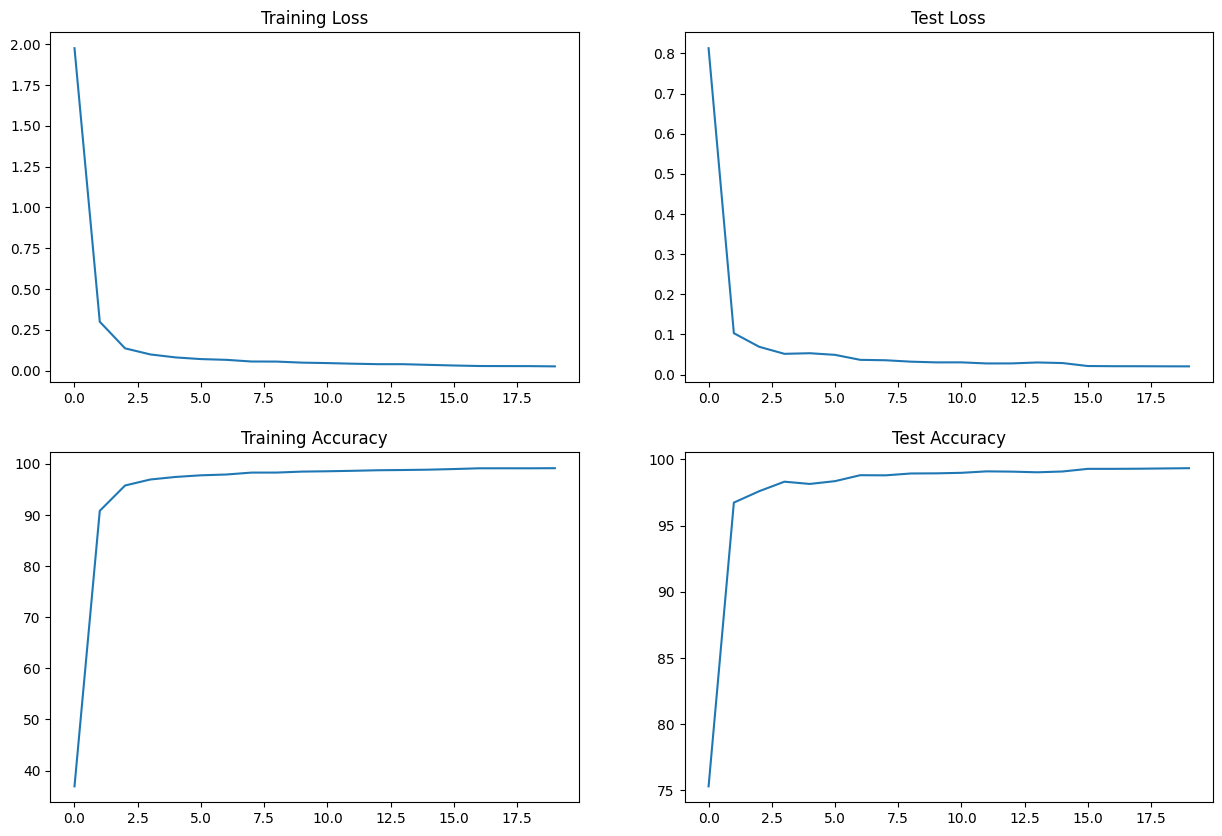

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

RuntimeError: shape '[-1, 320]' is invalid for input of size 8192

In [ ]:
x = 14
id(x)

136169082241680

In [ ]:
x = x*2
id(x)

136169082242128

In [ ]:
x =torch.randn(5, 5) #requires_grad = False by defaults
y =torch.randn(5, 5) #requires_grad = False by defaults
z =torch.randn((5, 5), requires_grad=True)
a1 = a.reshape(-1 , a.numel())

In [ ]:
a = x+ y

In [ ]:
print(a.grad)

None


In [ ]:
b = a + z

In [ ]:
print(b.grad)

None


<ipython-input-62-7fe73192bb7e>:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  print(b.grad)


In [ ]:
print(z.grad)

None


In [ ]:
a.requires_grad

False

In [ ]:
b.requires_grad

True

In [ ]:
a1.backward()

AttributeError: 'int' object has no attribute 'backward'

In [ ]:
a1.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
b1 = b.reshape(b.numel())

In [ ]:
a1

tensor([[ 2.0582e+00,  1.9267e+00, -1.2615e+00,  1.4585e+00, -1.1428e+00,
         -1.5950e+00,  1.0370e-01,  2.1762e+00,  9.8139e-02, -7.3295e-01,
         -5.0848e-01,  1.2637e+00,  3.3085e+00, -1.2452e+00,  2.5809e+00,
          5.6486e-01, -1.3430e+00, -2.3105e-01, -1.3656e+00,  4.0378e-01,
          7.4642e-01,  1.9134e-01,  5.4302e-01,  9.8044e-04, -1.7754e+00]])

In [ ]:
b1.sum()

tensor(9.3712, grad_fn=<SumBackward0>)

In [ ]:
b1.sum().backward()

In [ ]:
b1.grad

<ipython-input-88-55dbc2ecebe4>:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  b1.grad


In [ ]:
t = torch.tensor([
    [1, 0, 0, 2],
    [0, 3, 3, 0],
    [4, 0, 0, 5]
], dtype=torch.float32)

In [ ]:
t1